In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pysindy as ps
%matplotlib inline

### Task 1.1 Reconstructing a dynamical system from data using PySINDy

In [2]:
# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x, y, z = y
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

In [3]:
# Generate data
t_span = (0, 30)
initial_conditions = [1.0, 1.0, 1.0]
t_eval = np.linspace(t_span[0], t_span[1], 3000)
sol = solve_ivp(lorenz_system, t_span, initial_conditions, t_eval=t_eval, method='RK45')

### Task 1.2 Fitting a model

In [4]:
# Initialize a SINDy model
feature_library = ps.PolynomialLibrary(degree=6)
optimizer = ps.STLSQ(threshold=0.1)
model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)
model.fit(sol.y.T, t=sol.t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=6),
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ())

In [5]:
model.print()
simulated_data = model.simulate(initial_conditions, sol.t)

(x0)' = -9.983 x0 + 9.983 x1
(x1)' = 27.561 x0 + -0.909 x1 + -0.987 x0 x2
(x2)' = -2.659 x2 + 0.996 x0 x1


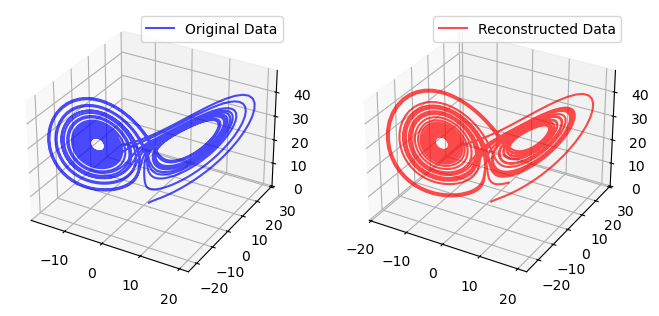

In [6]:
# 3D plot
fig = plt.figure(figsize=(16, 8))

# Original Data
ax = fig.add_subplot(221, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2], label='Original Data', color='blue', alpha=0.7)
ax.legend()

# Reconstructed Data
ax = fig.add_subplot(211, projection='3d')
ax.plot(simulated_data[:, 0], simulated_data[:, 1], simulated_data[:, 2], label='Reconstructed Data', color='red', alpha=0.7)
ax.legend()

### Task 1.3 Performance Measure

In [7]:
from tqdm import tqdm

In [8]:
# Function to calculate forward prediction error
def calculate_mse(N):
    mse = 0
    count = 0
    for i in tqdm(range(len(sol.t) - N)):
        actual = sol.y[:, i + N]
        predicted = model.simulate(sol.y[:, i], t=[0, N * np.mean(np.diff(sol.t))])[-1]
        mse += np.mean((actual - predicted)**2)
        count += 1
    return mse / count

# Test various N values
N_values = [1, 2, 5, 10, 20]
errors = {N: calculate_mse(N) for N in N_values}

# Print MSE for different N values
for N, error in errors.items():
    print(f"MSE for N={N}: {error}")

  0%|          | 0/2999 [00:00<?, ?it/s]

100%|██████████| 2980/2980 [2:34:55<00:00,  3.12s/it]    

MSE for N=1: 3.272173530355352e-05
MSE for N=2: 0.0001154139389494567
MSE for N=5: 0.0004238227890795276
MSE for N=10: 0.0009600454122410672
MSE for N=20: 0.003202150946202021


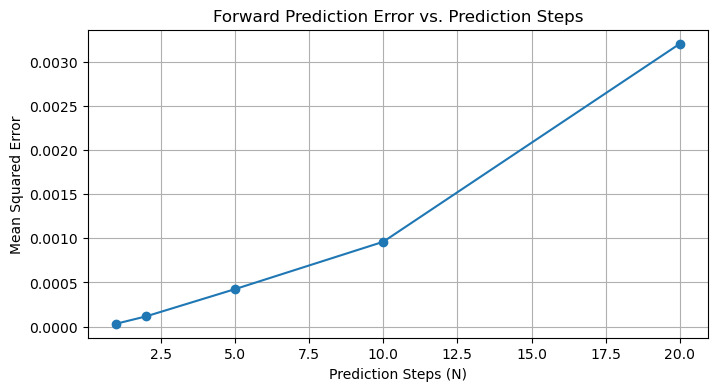

In [9]:
# Plot the MSE values
plt.figure(figsize=(8, 4))
plt.plot(list(errors.keys()), list(errors.values()), marker='o')
plt.xlabel('Prediction Steps (N)')
plt.ylabel('Mean Squared Error')
plt.title('Forward Prediction Error vs. Prediction Steps')
plt.grid(True)